In [1]:
! nvidia-smi

Tue Jan 25 19:31:52 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.46       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   46C    P8    30W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
! if [ -d HSE.Deep_Unsupervised_Learning ]; then rm -Rf HSE.Deep_Unsupervised_Learning; fi
! git clone https://github.com/SpirinEgor/HSE.Deep_Unsupervised_Learning.git
%cd HSE.Deep_Unsupervised_Learning
! git checkout hw8

Cloning into 'HSE.Deep_Unsupervised_Learning'...
remote: Enumerating objects: 757, done.
remote: Counting objects: 100% (231/231), done.
remote: Compressing objects: 100% (131/131), done.
remote: Total 757 (delta 121), reused 135 (delta 84), pack-reused 526
Receiving objects: 100% (757/757), 73.65 MiB | 13.40 MiB/s, done.
Resolving deltas: 100% (353/353), done.
/content/HSE.Deep_Unsupervised_Learning
Branch 'hw8' set up to track remote branch 'hw8' from 'origin'.
Switched to a new branch 'hw8'


In [3]:
! pip install -r requirements.txt

In [4]:
! git pull

Already up to date.


In [5]:
! unzip -qq Homework/hw1/data/hw1_data.zip -d Homework/hw1/data/
! mv -v Homework/hw1/data/hw1_data/* Homework/hw1/data/
! rm -rf Homework/hw1/data/hw1_data/

renamed 'Homework/hw1/data/hw1_data/geoffrey-hinton.jpg' -> 'Homework/hw1/data/geoffrey-hinton.jpg'
renamed 'Homework/hw1/data/hw1_data/mnist_colored.pkl' -> 'Homework/hw1/data/mnist_colored.pkl'
renamed 'Homework/hw1/data/hw1_data/mnist.pkl' -> 'Homework/hw1/data/mnist.pkl'
renamed 'Homework/hw1/data/hw1_data/shapes_colored.pkl' -> 'Homework/hw1/data/shapes_colored.pkl'
renamed 'Homework/hw1/data/hw1_data/shapes.pkl' -> 'Homework/hw1/data/shapes.pkl'
renamed 'Homework/hw1/data/hw1_data/smiley.jpg' -> 'Homework/hw1/data/smiley.jpg'


In [1]:
%cd ../..

/Users/Egor.Spirin/HSE/HSE.Deep_Unsupervised_Learning


In [5]:
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader, Dataset

from utils.hw8_utils import *
from dre.kmm import KernelMeanMatching, KMMTrainer
from dre.avb import AVB

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
plt.rcParams["axes.labelsize"] = 25.0
plt.rcParams["xtick.labelsize"] = 20.0
plt.rcParams["ytick.labelsize"] = 20.0
plt.rcParams["legend.fontsize"] = 18.0

plt.rcParams["figure.figsize"] = [8.0, 6.0]

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

# Question 1. KMM

## Notations from practice

*   $p_{nu}(x)$ - pdf of numerator
*   $p_{de}(x)$ - pdf of denominator
*   $r(x)=\frac{p_{nu}(x)}{p_{de}(x)}$ - density ratio
*   $p_{nu}^*, p_{du}^*, r^*$ - estimatinos of respective functions
*   $\{x^{nu}_i\}_{i=1}^{n_{nu}}$ - sample from numerator distribution
*   $\{x^{de}_i\}_{i=1}^{n_{de}}$ - sample from denominator distribution



## KMM objective

Here we will implement Kernel Mean Matching (KMM) method for density ratio estimation. The basic idea of KMM is to 'match' expections of kernel function:

$$argmin_{r^*} ||E_{p_{de}}r^*(x)K(\cdot, x) - E_{p_{nu}}K(\cdot, x)||$$

Where $K(x, x') = exp(-\frac{|x-y|^2}{2\sigma^2})$. Emperical variant of this objective can be rewritten as follows:

$$argmin_{r^*} \frac{1}{n_{de}^2} (r^*_{de})^t K_{de, de} r^*_{de} - \frac{2}{n_{nu}n_{de} }(r^*_{de})^t K_{de, nu}1_{n_{nu}}$$

Where


*   $r^*_{de}$ - vector with $(r^*_{de})_i=r^*(x^{de}_i)$
*   $K_{de, de}$ - matrix with $(K_{de, de})_{i, j} = K(x^{de}_i, x^{de}_j)$
*   $K_{de, nu}$ - matrix with $(K_{de, nu})_{i, j} = K(x^{de}_i, x^{nu}_j)$
*   $1_{n_{nu}}$ - vector with $n_{nu}$ ones


## You will provide these deliverables
Density ratio on $[-2, 2]$.


<Figure size 576x432 with 0 Axes>

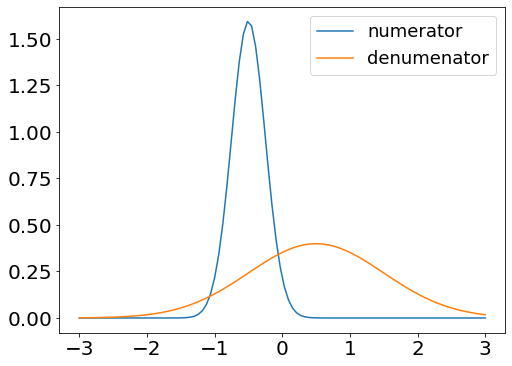

In [9]:
plot_data_q1()

In [10]:
def q1(data_nu, data_de):
    """
    data_nu - An [n_nu] dataset with samples from numerator's distribution
    data_de - An [n_de] dataset with samples from denominators's distribution

    Returns
      - a np.array with density ratios of np.linspace(-2., 2, num=100)
    """
    batch_size = 512
    lr = 1e-3
    epochs = 100

    sigma = 0.1
    hd = 256

    data_nu = torch.tensor(data_nu.reshape(-1, 1), dtype=torch.float, device=device)
    data_de = torch.tensor(data_de.reshape(-1, 1), dtype=torch.float, device=device)

    dataloader_nu = DataLoader(data_nu, batch_size=batch_size, shuffle=True)
    dataloader_de = DataLoader(data_de, batch_size=batch_size, shuffle=True)

    kmm = KernelMeanMatching(1, sigma, hd).to(device)
    trainer = KMMTrainer(kmm, device=device)

    trainer.fit(dataloader_nu, dataloader_de, lr, epochs)

    x = np.linspace(-2.0, 2, num=100)
    x = torch.tensor(x.reshape(-1, 1), dtype=torch.float, device=device)

    with torch.no_grad():
        kmm.eval()
        return kmm(x).detach().cpu().numpy()

  0%|          | 0/100 [00:00<?, ?it/s]

<Figure size 576x432 with 0 Axes>

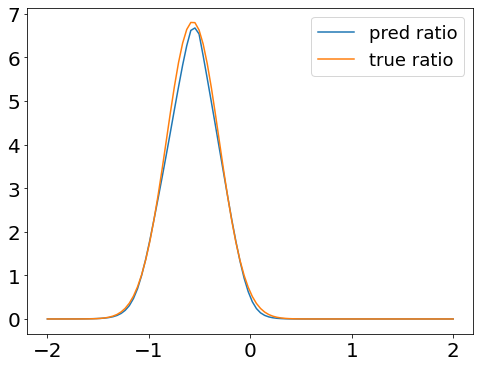

In [11]:
q1_results(q1)

# Question 2. AVB

Here we will implement [Adversairal Variational Bayes](https://dl.acm.org/doi/pdf/10.5555/3305890.3305928).

You may experiment with different hyperparameters and architecture designs, but the following designs for the AVB architecture may be useful.

```
Classifier (T)
    Conv2d(1, 32, 3, 1, 1), 
    ReLU(),
    Conv2d(32, 64, 3, 2, 1),
    ReLU(), 
    Conv2d(64, 128, 3, 2, 1), 
    ReLU(), 
    Conv2d(128, 128, 3, 2, 1), 
    ReLU(),
    # reshape + add latent
    Linear(4 * 4 * 128 + ld, hd), 
    ReLU(),
    Linear(hd, hd), 
    ReLU(),
    Linear(hd, 1)


Encoder (E)

    Conv2d(1, 32, 3, 1, 1), 
    ReLU(),
    Conv2d(32, 64, 3, 2, 1),
    ReLU(), 
    Conv2d(64, 128, 3, 2, 1), 
    ReLU(), 
    Conv2d(128, 128, 3, 2, 1), 
    ReLU(), 
    # add noise + reshape
    Linear(4 * 4 * 128 + nd, ld)

Decoder (D)
    ConvTranspose2d(128, 128, 3, 2, 1), 
    ReLU(), 
    ConvTranspose2d(128, 64, 4, 2, 1), 
    ReLU(), 
    ConvTranspose2d(64, 32, 4, 2, 1), 
    ReLU(), 
    Conv2d(32, 1, 3, 1, 1)
    # reshape
    Linear(ld, 4 * 4 * 128), 
    ReLU()
```

**Reminder.** Objective for AVB

$$max_{\theta, \phi} E \log p_\theta(x|z_\phi(x)) - T(x, z_\phi(x))$$
$$max_{T} E_x \bigg(E_{q_\phi(z|x)} \log\big(\sigma (T(x, z))\big) + E_{p(z)} \log\big(1 - \sigma (T(x, z))\big)\bigg) $$

$\phi$ - parameters of encoder, $\theta$ - parameters of decoder


**You will provide the following deliverables**


1.   Over the course of training, record the elbo and loss of the classifier T ber batch.
2. Report the final test set performances of your final models
3. 100 samples from your trained AVB

In [6]:
class Dataset(Dataset):
    def __init__(self, data):
        self.data = torch.tensor(data.transpose(0, 3, 1, 2), dtype=torch.float32)
    def __len__(self):
        return self.data.shape[0]
    def __getitem__(self, index):
        return self.data[index]

def q2(train_data, test_data):
    """
    train_data - A (n_train, 28, 28, 1) uint8 numpy array of binary images with values in {0, 1}
     Returns
    - a (# of training iterations,) numpy array of elbo_losses evaluated every minibatch
    - a (# of training iterations,) numpy array of classifier_losses evaluated every minibatch
    - a torch tensor of size (100, 1, 28, 28) of samples with values in {0, 1}
    """
    train_loader = DataLoader(Dataset(train_data), batch_size=256, shuffle=True)
    test_loader = DataLoader(Dataset(test_data), batch_size=256)

    model = AVB(latent_dim=64, device=device, noise_dim=4)
    train_losses, test_losses = model.fit(train_loader, test_loader, n_epochs=1, lr=1e-3)

    samples = model.sample(100)

    return train_losses[:, 0], train_losses[:, 1], test_losses[:, 0], test_losses[:, 1], samples

In [7]:
q2_results(q2)

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epochs:   0%|          | 0/1 [00:00<?, ?it/s]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

KeyboardInterrupt: 